# 1. 논문 재현
- Stock prediction using combination of BERT sentiment analysis and Macro economy index
    - news data : get_data_yahoo API
    - historical data : 다우존스, 국제 금값, WTI, INR=X, JPY=X, CNY=X, CAD=X, EURUSD=X의 Adjusted close, close, low, high, open price를 각각 수집
    - 기간 : 2018년 1월 1일 부터 2019년 12월 31일
    - BERT, NLTK VADER, LSTM 사용

In [3]:
import tensorflow
tensorflow.__version__

'2.9.1'

In [27]:
import json
import numpy as np
import pandas as pd

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
import regex as re
from nltk.corpus import stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer
import datetime

import yfinance as yf
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers
from keras import backend as K
import matplotlib.pyplot as plt

## news data 수집

In [115]:
dir = "C:/Users/default.DESKTOP-IT64657/Desktop/논문code/headline data/"

year_month = ["2018_1","2018_2","2018_3","2018_4","2018_5","2018_6","2018_7","2018_8","2018_9","2018_10","2018_11","2018_12",
             "2019_1","2019_2","2019_3","2019_4","2019_5","2019_6","2019_7","2019_8","2019_9","2019_10","2019_11","2019_12",]

j=0
m = len(year_month)
headline = [0]*m
date = [0]*m
for i in year_month:
    with open(dir+str(i)+".json", 'r', encoding= "UTF-8") as f:
        json_data = json.load(f)
    n = len(json_data["response"]["docs"])
    headline[j] = [0]*n
    date[j] = [0]*n
    
    for k in range(n):
        headline[j][k] = json_data["response"]["docs"][k]["headline"]["main"]
        date[j][k] = json_data["response"]["docs"][k]["pub_date"]
    j += 1

In [116]:
# hesline과 date를 수집
headline = np.hstack(headline)
date = np.hstack(date)
headline = pd.DataFrame({"headline":headline, "date":date})

In [117]:
# date를 datetime으로 형식 변환
headline.date = headline.date.apply(lambda x: pd.to_datetime(x, errors="ignore"))

## news data 전처리

In [118]:
#####-----------------------------------------------------------------------------
# 토큰화
headline_token = headline.headline.apply(lambda x:word_tokenize(x))



#####-----------------------------------------------------------------------------
# 구두점 제거
#fullstop = re.compile(r'[,—"“”‘’\'-?:!;\\]')
#headline_token = headline_token.apply(lambda x: fullstop.sub(" ",x))




#####-----------------------------------------------------------------------------
# 표제어 추출(WordNetLemmatizer 사용)
def lemmatization_line(line):   ## 한 리스트의 한 문장씩 불러와서 lemmatization_line 적용
    line = list(map(lemmatization_word, line))
    return line

def lemmatization_word(data):  ## string 형식, 한 문장의 한 단어씩 불러와서 표제어 추출
    n=WordNetLemmatizer()
    data = n.lemmatize(data)
    return data

headline_token = headline_token.apply(lambda x: lemmatization_line(x))




#####-----------------------------------------------------------------------------
# 표제어 추출(Poster 사용)
ps = PorterStemmer()

def lemmatization_line(line):   ## 한 리스트의 한 문장씩 불러와서 lemmatization_line 적용
    line = list(map(lemmatization_word, line))
    return line

def lemmatization_word(data):  ## string 형식, 한 문장의 한 단어씩 불러와서 표제어 추출
    n=WordNetLemmatizer()
    data = ps.stem(data)
    return data

headline_token = headline_token.apply(lambda x: lemmatization_line(x))




#####-----------------------------------------------------------------------------
# 대소문자 변환
def upper_to_lower_line(line):  ## 한 리스트의 한 문장씩 불러와서 upper_to_lower_word 적용
    line = list(map( upper_to_lower_word, line))
    return line

def upper_to_lower_word(word):  ## string 형식, 한 문장의 한 단어씩 불러와서 대문자 변환   The -> the, THE -> THE
    word = re.sub("^[A-Z]{1}[a-z]*$",word.lower(),word)  ## 정규표현식에 맞는 단어만 lower 적용
    return word

headline_token = headline_token.apply(lambda x: upper_to_lower_line(x))





#####-----------------------------------------------------------------------------
# 불용어 제거
def del_stopword(line):              ## 한 리스트의 한 문장씩 불러와서 dir_stopword_produce 적용
    dir_stop_words = stopwords.words('english')  ## 불용어 사전
    
    line_stopwords_intersection = list(set(line)& set(dir_stop_words))   ## 각 문장과 불용어 사전에 동시에 있는 단어 추출
    
    # 각 문장마다 불용어 사전과 교집합인 사전 생성
    
    # 각 문장마다 교집합 사전에 해당하지 않는 값만 추출
    line = difference(line, line_stopwords_intersection)  
    
    return line


def difference(line, line_stopwords_intersection):      ## 각 문장, 각 문장과 불용어 사전의 교집합 입력
    line = [i for i in line if i not in line_stopwords_intersection]  ## 불용어 사전에 해당하지 않는 단어만 추출
    return line

headline_token = headline_token.apply(lambda x: del_stopword(x))

In [119]:
# 처리한 token 하나의 문장으로 결합
def word_to_sentence(lst):  ## 토큰화가 되어있는 tit, tit 데이터를 한 문장으로 만듦
    lst = " ".join(lst)     ## ex) the, and, me, bye => the and me bye
    return lst

headline_sentence= headline_token.apply(lambda x: word_to_sentence(x))

In [120]:
headline_sentence = pd.DataFrame(headline_sentence)

## 감정분석 : NLTK VADER

In [121]:
analyzer = SentimentIntensityAnalyzer()

headline_sentence["Score"]=0

for i in range(len(headline_sentence)):
    score = analyzer.polarity_scores(headline_sentence.headline[i])       # 감성점수 추출
    headline_sentence.Score[i] = score["compound"]

<ipython-input-121-c8d6b64a7276>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  headline_sentence.Score[i] = score["compound"]


In [122]:
headline_sentence["class_3"] = 0
for i in range(len(headline_sentence)):
    if (headline_sentence.Score[i] <0.2)&(headline_sentence.Score[i]>-0.2):
        headline_sentence.class_3[i] = 0
    elif (headline_sentence.Score[i] >=0.2):
        headline_sentence.class_3[i] = 1
    elif (headline_sentence.Score[i] <=-0.2):
        headline_sentence.class_3[i] = -1

<ipython-input-122-31f861755797>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  headline_sentence.class_3[i] = 0
<ipython-input-122-31f861755797>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  headline_sentence.class_3[i] = -1
<ipython-input-122-31f861755797>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  headline_sentence.class_3[i] = 1


In [123]:
headline_sentence["date"] = headline.date

In [125]:
Date = pd.date_range(start='20180101', end='20200101')
Date = pd.DataFrame({"Date" : Date.values})

In [215]:
## 다음날을 예측하도록 구성
headline_sentence["prediction_day"] = 0
standard_date = pd.Timestamp(datetime.datetime.strftime(headline_sentence.date[0], "%Y-%m-%d"),tz="UTC") + datetime.timedelta(hours=16)
for i in range(len(headline_sentence)):
    if standard_date > headline_sentence.date[i]:
        headline_sentence.prediction_day[i] = pd.Timestamp(datetime.datetime.strftime(standard_date, "%Y-%m-%d"),tz="UTC")
    elif standard_date <= headline_sentence.date[i]:
        standard_date = standard_date+ datetime.timedelta(days = 1)
        headline_sentence.prediction_day[i] = pd.Timestamp(datetime.datetime.strftime(standard_date, "%Y-%m-%d"),tz="UTC")

<ipython-input-215-5fa77a271ba6>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  headline_sentence.prediction_day[i] = pd.Timestamp(datetime.datetime.strftime(standard_date, "%Y-%m-%d"),tz="UTC")


In [216]:
# 같은 날의 news score은 평균으로 계산
score_mean = headline_sentence.groupby("prediction_day")["class_3"].mean()
score_mean = score_mean.reset_index()

In [217]:
score_mean["N"] = headline_sentence.groupby("prediction_day")["class_3"].count().reset_index()["class_3"]

## Price data

In [219]:
price_data = yf.download(["^DJI"],start = '2017-12-31', end = "2020-01-01")

[*********************100%***********************]  1 of 1 completed


In [220]:
#price_data = price_data["Close"].reset_index()
price_data = price_data.reset_index()
len(price_data)

503

In [221]:
first_data = yf.download(["^DJI"],start = '2017-12-30', end = '2017-12-31')


[*********************100%***********************]  1 of 1 completed


In [222]:
def time_conversion(time):
    time = pd.Timestamp(time, tz = "UTC")
    return time

price_data.Date = price_data.Date.apply(lambda x: time_conversion(x))

In [242]:
standard_time = price_data.Date[0]
j = 0
score = 0
n = 0
score_mean["Score"]=0
for i in range(len(score_mean)-1):
    standard_time = price_data.Date[j]
    if score_mean.prediction_day[i]<standard_time:
        score += score_mean.class_3[i]*score_mean.N[i]
        n +=score_mean.N[i]
    elif score_mean.prediction_day[i]==standard_time:
        j+=1
        score += score_mean.class_3[i]*score_mean.N[i]
        n +=score_mean.N[i]
        score_mean.Score[i]= score/n
        score = 0
        n=0

<ipython-input-242-9ba825726141>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  score_mean.score[i]= score/n


In [246]:
# 현재 종가를 예측하기 위해 사용할 이전 종가 데이터 만들기
x_y = pd.merge(price_data, score_mean, how ="left",left_on='Date', right_on = "prediction_day")[["Close","Open","High","Low","Adj Close","Score"]]
x_y = x_y.dropna(axis=0)
x_y["before_close"] = 0
x_y = x_y.reset_index(drop=True)
for i in range(len(x_y)-1):
    x_y.before_close[i+1] = x_y.Close[i]
x_y.before_close[0] = first_data["Close"][0]

for i in range(len(x_y)):
    x_y.High[len(x_y)-i] =x_y.High[len(x_y)-i-1]
    x_y.Open[len(x_y)-i] =x_y.Open[len(x_y)-i-1]
    x_y.Low[len(x_y)-i] =x_y.Low[len(x_y)-i-1]
    x_y["Adj Close"][len(x_y)-i] =x_y["Adj Close"][len(x_y)-i-1]

x_y.High[0] = first_data["High"][0]
x_y.Open[0] = first_data["Open"][0]
x_y.Low[0] = first_data["Low"][0]
x_y["Adj Close"][0] = first_data["Adj Close"][0]


x_y = pd.DataFrame(MinMaxScaler().fit_transform(x_y))
x_y.columns = ["Close","before_Open","before_High","before_Low","before_Adj Close","Score","before_close"]

<ipython-input-246-f3d0cc54194b>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_y.before_close[i+1] = x_y.Close[i]


## Model 생성

In [251]:
train_index = int(len(x_y)*0.7)

train = x_y.iloc[0:train_index]
test = x_y.iloc[train_index:len(x_y)]


train_x = train[["before_Open","before_High","before_Low","before_Adj Close","Score","before_close"]]
train_y = train[["Close"]]

test_x = test[["before_Open","before_High","before_Low","before_Adj Close","Score","before_close"]]
test_y = test[["Close"]]

In [252]:
train_x = train_x.to_numpy().reshape(len(train_x),1,6)
train_y = train_y.to_numpy().reshape(len(train_y),1)
test_x = test_x.to_numpy().reshape(len(test_x),1,6)
test_y = test_y.to_numpy().reshape(len(test_y),1)

In [253]:
window_size = 30

In [254]:
x = np.zeros(shape=(len(train_x)-window_size+1,window_size,6))
for i in range(len(train_x)-window_size+1):
    x[i]=np.vstack((train_x[i:i+window_size]))
    
y = train_y[window_size-1:len(train_y)]

x_t = np.zeros(shape=(len(test_x)-window_size+1,window_size,6))
for i in range(len(test_x)-window_size+1):
    x_t[i]=np.vstack((test_x[i:i+window_size]))
    
y_t = test_y[window_size-1:len(test_y)]

In [262]:
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 

model = Sequential()
model.add(LSTM(64, input_shape = (x.shape[1],x.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1,activation="tanh"))
model.compile(optimizer='adam', loss = root_mean_squared_error, metrics=['mse'])
history = model.fit(x, y, epochs=200, batch_size=512, validation_split=0.2)


Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 0.4298 - mse: 0.1847 - val_loss: 0.3684 - val_mse: 0.1357
Epoch 2/200
1/1 [==============================] - 0s 125ms/step - loss: 0.2921 - mse: 0.0853 - val_loss: 0.2092 - val_mse: 0.0438
Epoch 3/200
1/1 [==============================] - 0s 136ms/step - loss: 0.1677 - mse: 0.0281 - val_loss: 0.0699 - val_mse: 0.0049
Epoch 4/200
1/1 [==============================] - 0s 143ms/step - loss: 0.1260 - mse: 0.0159 - val_loss: 0.0712 - val_mse: 0.0051
Epoch 5/200
1/1 [==============================] - 0s 145ms/step - loss: 0.1686 - mse: 0.0284 - val_loss: 0.0791 - val_mse: 0.0063
Epoch 6/200
1/1 [==============================] - 0s 142ms/step - loss: 0.1777 - mse: 0.0316 - val_loss: 0.0626 - val_mse: 0.0039
Epoch 7/200
1/1 [==============================] - 0s 141ms/step - loss: 0.1621 - mse: 0.0263 - val_loss: 0.0556 - val_mse: 0.0031
Epoch 8/200
1/1 [==============================] - 0s 137ms/step - loss: 0.1284 - mse:

In [263]:
model.evaluate(x_t, y_t)

4/4 [==============================] - 0s 8ms/step - loss: 0.0750 - mse: 0.0059


[0.07495591044425964, 0.005888042971491814]

4/4 [==============================] - 1s 7ms/step


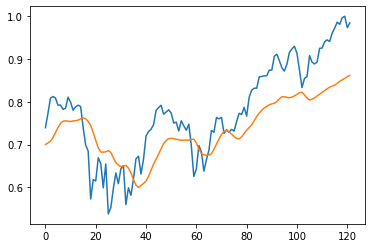

In [264]:
plt.plot(y_t)
plt.plot(model.predict(x_t))

In [69]:
from tensorflow.python.keras.models import load_model
model.save("lstm_model_1_0038.h5")

# 2. 논문과 동일(데이터만 다름)

- news data : nbc 데이터 사용
- historical data : senment score, 다우존스의 open, close, low, high, adj close 사용
- 기간 : 2018년 1월 1일 ~ 2019년 12월 31일 까지

In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import yfinance as yf
import datetime

2022-11-13 22:34:31.555297: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-13 22:34:31.654354: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-11-13 22:34:31.658244: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-13 22:34:31.658257: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if yo

In [3]:
dir = "/home/whfhrs3260/csv_data"

In [4]:
score = pd.read_csv(dir+"/price_data_score.csv")
score.columns = ["Date", "Score", "class_3", "class_5"]

In [5]:
score = score[["Date","class_3"]]

In [29]:
price_data = yf.download(["^DJI"],start = '2017-12-31', end = "2020-01-01")
price_data = price_data.reset_index()

[*********************100%***********************]  1 of 1 completed


In [30]:
first_data = yf.download(["^DJI"],start = '2017-12-29', end = '2018-01-01')

[*********************100%***********************]  1 of 1 completed


In [31]:
price_data.Date[0]

Timestamp('2018-01-02 00:00:00')

In [32]:
def time_conversion(time):
    time = pd.Timestamp(time)
    return time

score.Date = score.Date.apply(lambda x: time_conversion(x))

In [33]:
score.iloc[249:751]

,Date,class_3
249,2018-01-02,0.092784
250,2018-01-03,0.028571
251,2018-01-04,0.065217
252,2018-01-05,0.000000
253,2018-01-08,0.337662
...,...,...
746,2019-12-31,0.309091
747,2020-01-02,0.235955
748,2020-01-03,0.156863
749,2020-01-06,-0.102362


In [34]:
price_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-01-02,24809.349609,24864.189453,24741.699219,24824.009766,24824.009766,341130000
1,2018-01-03,24850.449219,24941.919922,24825.550781,24922.679688,24922.679688,456790000
2,2018-01-04,24964.859375,25105.960938,24963.269531,25075.130859,25075.130859,403280000
3,2018-01-05,25114.919922,25299.789062,25112.009766,25295.869141,25295.869141,358020000
4,2018-01-08,25308.400391,25311.990234,25235.410156,25283.000000,25283.000000,341390000
...,...,...,...,...,...,...,...
498,2019-12-24,28572.570312,28576.800781,28503.210938,28515.449219,28515.449219,86150000
499,2019-12-26,28539.460938,28624.099609,28535.150391,28621.390625,28621.390625,155970000
500,2019-12-27,28675.339844,28701.660156,28608.980469,28645.259766,28645.259766,182280000
501,2019-12-30,28654.759766,28664.689453,28428.980469,28462.140625,28462.140625,181600000


In [35]:
price_data = pd.merge(price_data, score, how ="left",left_on='Date', right_on = "Date")[["Close","Open","High","Low","Adj Close","class_3"]]
price_data.class_3[price_data.class_3.isnull()]=0
price_data["before_close"] = 0
price_data = price_data.reset_index(drop=True)
for i in range(len(price_data)-1):
    price_data.before_close[i+1] = price_data.Close[i]
    
price_data.before_close[0] = first_data["Close"][0]

for i in range(len(price_data)):
    price_data.High[len(price_data)-i] =price_data.High[len(price_data)-i-1]
    price_data.Open[len(price_data)-i] =price_data.Open[len(price_data)-i-1]
    price_data.Low[len(price_data)-i] =price_data.Low[len(price_data)-i-1]
    price_data["Adj Close"][len(price_data)-i] =price_data["Adj Close"][len(price_data)-i-1]

price_data.High[0] = first_data["High"][0]
price_data.Open[0] = first_data["Open"][0]
price_data.Low[0] = first_data["Low"][0]
price_data["Adj Close"][0] = first_data["Adj Close"][0]


price_data = pd.DataFrame(MinMaxScaler().fit_transform(price_data))
price_data.columns = ["Close","before_Open","before_High","before_Low","before_Adj Close","class_3","before_close"]

/tmp/ipykernel_142583/292413663.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data.before_close[i+1] = price_data.Close[i]


In [36]:
price_data

,Close,before_Open,before_High,before_Low,before_Adj Close,class_3,before_close
0,0.442402,0.438849,0.397968,0.435977,0.427112,0.482442,0.427112
1,0.456800,0.432940,0.396794,0.439236,0.442402,0.417329,0.442402
2,0.479046,0.438969,0.409012,0.451395,0.456800,0.454489,0.456800
3,0.511256,0.455751,0.434798,0.471364,0.479046,0.388356,0.479046
4,0.509378,0.477761,0.465265,0.492932,0.511256,0.730760,0.511256
...,...,...,...,...,...,...,...
498,0.981058,0.973076,0.981268,0.983006,0.986323,0.476534,0.986323
499,0.996517,0.984926,0.980374,0.984663,0.981058,0.388356,0.981058
500,1.000000,0.980069,0.987808,0.989294,0.996517,0.546096,0.996517
501,0.973279,1.000000,1.000000,1.000000,1.000000,0.388356,1.000000


In [37]:
train_index = int(len(price_data)*0.7)

train = price_data.iloc[0:train_index]
test = price_data.iloc[train_index:len(price_data)]


train_x = train[["before_Open","before_High","before_Low","before_Adj Close","class_3","before_close"]]
train_y = train[["Close"]]

test_x = test[["before_Open","before_High","before_Low","before_Adj Close","class_3","before_close"]]
test_y = test[["Close"]]

In [38]:
train_x

,before_Open,before_High,before_Low,before_Adj Close,class_3,before_close
0,0.438849,0.397968,0.435977,0.427112,0.482442,0.427112
1,0.432940,0.396794,0.439236,0.442402,0.417329,0.442402
2,0.438969,0.409012,0.451395,0.456800,0.454489,0.456800
3,0.455751,0.434798,0.471364,0.479046,0.388356,0.479046
4,0.477761,0.465265,0.492932,0.511256,0.730760,0.511256
...,...,...,...,...,...,...
347,0.557025,0.536302,0.557971,0.567294,0.539706,0.567294
348,0.575658,0.559339,0.589735,0.596103,0.483000,0.596103
349,0.580956,0.556186,0.586183,0.581406,0.720829,0.581406
350,0.557418,0.521570,0.524264,0.539653,0.111800,0.539653


In [13]:
train_x = train_x.to_numpy().reshape(len(train_x),1,6)
train_y = train_y.to_numpy().reshape(len(train_y),1)
test_x = test_x.to_numpy().reshape(len(test_x),1,6)
test_y = test_y.to_numpy().reshape(len(test_y),1)

NameError: name 'train_x' is not defined

In [14]:
window_size = 30

In [15]:
train_x.shape

NameError: name 'train_x' is not defined

In [54]:
x = np.zeros(shape=(len(train_x)-window_size+1,window_size,6))
for i in range(len(train_x)-window_size+1):
    x[i]=np.vstack((train_x[i:i+window_size]))

y = train_y[window_size-1:len(train_y)]

x_t = np.zeros(shape=(len(test_x)-window_size+1,window_size,6))
for i in range(len(test_x)-window_size+1):
    x_t[i]=np.vstack((test_x[i:i+window_size]))
    
y_t = test_y[window_size-1:len(test_y)]

In [82]:
model = Sequential()
model.add(LSTM(128, input_shape = (x.shape[1],x.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16))
model.add(Dense(1,activation="tanh"))
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
model.compile(optimizer='adam', loss = root_mean_squared_error, metrics=['mse'])
history = model.fit(x, y, epochs=200, batch_size=512, validation_split=0.2)

Epoch 1/200
1/1 [==============================] - 4s 4s/step - loss: 0.3910 - mse: 0.1529 - val_loss: 0.2519 - val_mse: 0.0635
Epoch 2/200
1/1 [==============================] - 0s 274ms/step - loss: 0.1638 - mse: 0.0268 - val_loss: 0.0553 - val_mse: 0.0031
Epoch 3/200
1/1 [==============================] - 0s 275ms/step - loss: 0.1391 - mse: 0.0194 - val_loss: 0.0676 - val_mse: 0.0046
Epoch 4/200
1/1 [==============================] - 0s 271ms/step - loss: 0.1738 - mse: 0.0302 - val_loss: 0.0558 - val_mse: 0.0031
Epoch 5/200
1/1 [==============================] - 0s 272ms/step - loss: 0.1524 - mse: 0.0232 - val_loss: 0.0686 - val_mse: 0.0047
Epoch 6/200
1/1 [==============================] - 0s 275ms/step - loss: 0.1149 - mse: 0.0132 - val_loss: 0.1284 - val_mse: 0.0165
Epoch 7/200
1/1 [==============================] - 0s 275ms/step - loss: 0.1035 - mse: 0.0107 - val_loss: 0.1768 - val_mse: 0.0313
Epoch 8/200
1/1 [==============================] - 0s 276ms/step - loss: 0.1227 - mse:

In [81]:
model.evaluate(x_t, y_t)

4/4 [==============================] - 0s 18ms/step - loss: 0.0920 - mse: 0.0091


[0.09197955578565598, 0.009138601832091808]

4/4 [==============================] - 0s 4ms/step


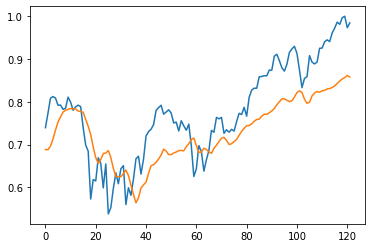

In [57]:
plt.plot(y_t)
plt.plot(model.predict(x_t))

# 3. 논문과 동일(데이터와 데이터 기간이 다름)

- news data : nbc 데이터 사용
- historical data : senment score, 다우존스의 open, close, low, high, adj close 사용
- 기간 : 2017년 1월 1일 ~ 2022년 4월 31일 까지

In [64]:
dir = "C:/Users/default.DESKTOP-IT64657/Desktop/논문code/csv_data"

In [65]:
score = pd.read_csv(dir+"/price_data_score.csv")
score.columns = ["Date", "Score", "class_3", "class_5"]
score = score[["Date","class_3"]]

In [66]:
price_data = yf.download(["^DJI"],start = '2017-01-01', end = "2022-05-01")
price_data = price_data.reset_index()

[*********************100%***********************]  1 of 1 completed


In [67]:
price_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-03,19872.859375,19938.529297,19775.929688,19881.759766,19881.759766,339180000
1,2017-01-04,19890.939453,19956.140625,19878.830078,19942.160156,19942.160156,280010000
2,2017-01-05,19924.560547,19948.599609,19811.119141,19899.289062,19899.289062,269920000
3,2017-01-06,19906.960938,19999.630859,19834.080078,19963.800781,19963.800781,277700000
4,2017-01-09,19931.410156,19943.779297,19887.380859,19887.380859,19887.380859,287510000
...,...,...,...,...,...,...,...
1336,2022-04-25,33731.648438,34106.011719,33323.371094,34049.460938,34049.460938,416900000
1337,2022-04-26,33907.488281,33909.511719,33230.949219,33240.179688,33240.179688,400020000
1338,2022-04-27,33450.921875,33697.179688,33108.890625,33301.929688,33301.929688,447230000
1339,2022-04-28,33425.960938,34054.789062,33248.460938,33916.390625,33916.390625,440380000


In [68]:
first_data = yf.download(["^DJI"],start = '2016-12-31', end = '2017-01-01')

[*********************100%***********************]  1 of 1 completed


In [69]:
first_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-12-30,19833.169922,19852.550781,19718.669922,19762.599609,19762.599609,271910000


In [70]:
def time_conversion(time):
    time = pd.Timestamp(time)
    return time

score.Date = score.Date.apply(lambda x: time_conversion(x))

In [71]:
price_data = pd.merge(price_data, score, how ="left",left_on='Date', right_on = "Date")[["Close","Open","High","Low","Adj Close","class_3"]]
price_data.class_3[price_data.class_3.isnull()]=0
price_data["before_close"] = 0
price_data = price_data.reset_index(drop=True)
for i in range(len(price_data)-1):
    price_data.before_close[i+1] = price_data.Close[i]
    
price_data.before_close[0] = first_data["Close"][0]

for i in range(len(price_data)):
    price_data.High[len(price_data)-i] =price_data.High[len(price_data)-i-1]
    price_data.Open[len(price_data)-i] =price_data.Open[len(price_data)-i-1]
    price_data.Low[len(price_data)-i] =price_data.Low[len(price_data)-i-1]
    price_data["Adj Close"][len(price_data)-i] =price_data["Adj Close"][len(price_data)-i-1]

price_data.High[0] = first_data["High"][0]
price_data.Open[0] = first_data["Open"][0]
price_data.Low[0] = first_data["Low"][0]
price_data["Adj Close"][0] = first_data["Adj Close"][0]

price_data.columns = ["Close","before_Open","before_High","before_Low","before_Adj Close","class_3","before_close"]

<ipython-input-71-b1ce5fe81da2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data.before_close[i+1] = price_data.Close[i]


In [72]:

x = price_data[["class_3","before_close"]]
y = price_data[["Close"]]
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

x = pd.DataFrame(scaler_x.fit_transform(x))
y = pd.DataFrame(scaler_y.fit_transform(y))

x.columns = ["class_3","before_close"]
y.columns = ["Close"]

train_index = int(len(x)*0.7)

train_x = x.iloc[0:train_index]
test_x = x.iloc[train_index:len(x)]

train_y = y.iloc[0:train_index]
test_y = y.iloc[train_index:len(y)]



In [73]:
x_t.shape

(374, 30, 2)

In [56]:
test_x.shape[0]

403

In [57]:
train_x = train_x.to_numpy().reshape(train_x.shape[0],1,train_x.shape[1])
train_y = train_y.to_numpy().reshape(train_y.shape[0],train_y.shape[1])
test_x = test_x.to_numpy().reshape(test_x.shape[0],1,test_x.shape[1])
test_y = test_y.to_numpy().reshape(test_y.shape[0],test_y.shape[1])

In [58]:
window_size = 30

In [59]:
x_t.shape

(374, 30, 30)

In [60]:
x = np.zeros(shape=(train_x.shape[0]-window_size+1,window_size,x.shape[1]))
for i in range(train_x.shape[0]-window_size+1):
    x[i]=np.vstack((train_x[i:i+window_size]))

y = train_y[window_size-1:train_x.shape[0]]

x_t = np.zeros(shape=(test_x.shape[0]-window_size+1,window_size,x.shape[2]))
for i in range(test_x.shape[0]-window_size+1):
    x_t[i]=np.vstack((test_x[i:i+window_size]))
    
y_t = test_y[window_size-1:test_x.shape[0]]

In [61]:
x_t

array([[[0.59868421, 0.44877677],
        [0.61764706, 0.45164965],
        [0.53515625, 0.47134028],
        ...,
        [0.60747664, 0.43441301],
        [0.46590909, 0.4576697 ],
        [0.61111111, 0.48815009]],

       [[0.61764706, 0.45164965],
        [0.53515625, 0.47134028],
        [0.5       , 0.49386367],
        ...,
        [0.46590909, 0.4576697 ],
        [0.61111111, 0.48815009],
        [0.80508475, 0.50834103]],

       [[0.53515625, 0.47134028],
        [0.5       , 0.49386367],
        [0.53676471, 0.48664693],
        ...,
        [0.61111111, 0.48815009],
        [0.80508475, 0.50834103],
        [0.62      , 0.53813716]],

       ...,

       [[0.425     , 0.82121272],
        [0.44202899, 0.84970402],
        [0.5       , 0.87264265],
        ...,
        [0.46721311, 0.83588004],
        [0.55084746, 0.84895486],
        [0.53731343, 0.8045077 ]],

       [[0.44202899, 0.84970402],
        [0.5       , 0.87264265],
        [0.46078431, 0.88770044],
        .

In [62]:
model = Sequential()
model.add(LSTM(128, input_shape = (x.shape[1],x.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(1,activation="tanh"))
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
model.compile(optimizer='adam', loss = root_mean_squared_error, metrics=['mse'])
history = model.fit(x, y, epochs=200, batch_size=64, validation_split=0.2)

Epoch 1/200


KeyboardInterrupt: 

In [396]:
model.evaluate(x, y)

29/29 [==============================] - 0s 12ms/step - loss: 0.0144 - mse: 3.2630e-04


[0.01439722254872322, 0.00032629945781081915]

In [397]:
model.evaluate(x_t, y_t)

12/12 [==============================] - 0s 13ms/step - loss: 0.0588 - mse: 0.0042


[0.058824121952056885, 0.004158635623753071]

=> 기간이 길어지니 확실히 나음

12/12 [==============================] - 1s 12ms/step


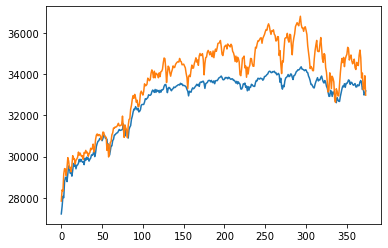

In [398]:
plt.plot(scaler_y.inverse_transform(model.predict(x_t)))
plt.plot(scaler_y.inverse_transform(y_t))

In [401]:
from sklearn.metrics import mean_squared_error 
mean_squared_error(scaler_y.inverse_transform(model.predict(x_t)),scaler_y.inverse_transform(y_t))

12/12 [==============================] - 0s 12ms/step


1378674.053126126

In [399]:
from keras.models import load_model
model.save('20221027_lstm_model3.h5')

In [ ]:
model.predict(x_t)

# 4. 논문과 동일(데이터와 데이터 기간와 변수가 다름)

- news data : nbc 데이터 사용
- historical data : senment score, 다우존스의 close 만 사용
- 기간 : 2017년 1월 1일 ~ 2022년 04월 31일 까지

In [108]:
dir = "C:/Users/default.DESKTOP-IT64657/Desktop/논문code/csv_data"

In [109]:
score = pd.read_csv(dir+"/price_data_score.csv")
score.columns = ["Date", "Score", "class_3", "class_5"]
score = score[["Date","class_3"]]

In [124]:
price_data = yf.download(["^DJI"],start = '2017-01-01', end = "2022-05-01")["Close"]
price_data = price_data.reset_index()

[*********************100%***********************]  1 of 1 completed


In [125]:
price_data

,Date,Close
0,2017-01-03,19881.759766
1,2017-01-04,19942.160156
2,2017-01-05,19899.289062
3,2017-01-06,19963.800781
4,2017-01-09,19887.380859
...,...,...
1336,2022-04-25,34049.460938
1337,2022-04-26,33240.179688
1338,2022-04-27,33301.929688
1339,2022-04-28,33916.390625


In [126]:
first_data = yf.download(["^DJI"],start = '2016-12-31', end = '2017-01-01')["Close"]

[*********************100%***********************]  1 of 1 completed


In [127]:
first_data

Date
2016-12-30    19762.599609
Name: Close, dtype: float64

In [128]:
def time_conversion(time):
    time = pd.Timestamp(time)
    return time

score.Date = score.Date.apply(lambda x: time_conversion(x))

In [129]:
price_data

,Date,Close
0,2017-01-03,19881.759766
1,2017-01-04,19942.160156
2,2017-01-05,19899.289062
3,2017-01-06,19963.800781
4,2017-01-09,19887.380859
...,...,...
1336,2022-04-25,34049.460938
1337,2022-04-26,33240.179688
1338,2022-04-27,33301.929688
1339,2022-04-28,33916.390625


In [130]:
price_data = pd.merge(price_data, score, how ="left",left_on='Date', right_on = "Date")[["Close","class_3"]]
price_data.class_3[price_data.class_3.isnull()]=0
price_data["before_close"] = 0
price_data = price_data.reset_index(drop=True)
for i in range(len(price_data)-1):
    price_data.before_close[i+1] = price_data.Close[i]


price_data.before_close[0] = first_data[0]


price_data = pd.DataFrame(MinMaxScaler().fit_transform(price_data))
price_data.columns = ["Close","class_3","before_close"]

<ipython-input-130-04be1271248a>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data.before_close[i+1] = price_data.Close[i]


In [131]:
train_index = int(len(price_data)*0.7)

train = price_data.iloc[0:train_index]
test = price_data.iloc[train_index:len(price_data)]


train_x = train[["class_3","before_close"]]
train_y = train[["Close"]]

test_x = test[["class_3","before_close"]]
test_y = test[["Close"]]

In [132]:
train_x = train_x.to_numpy().reshape(len(train_x),1,2)
train_y = train_y.to_numpy().reshape(len(train_y),1)
test_x = test_x.to_numpy().reshape(len(test_x),1,2)
test_y = test_y.to_numpy().reshape(len(test_y),1)

In [133]:
window_size = 30

In [134]:
x = np.zeros(shape=(len(train_x)-window_size+1,window_size,2))
for i in range(len(train_x)-window_size+1):
    x[i]=np.vstack((train_x[i:i+window_size]))

y = train_y[window_size-1:len(train_y)]

x_t = np.zeros(shape=(len(test_x)-window_size+1,window_size,2))
for i in range(len(test_x)-window_size+1):
    x_t[i]=np.vstack((test_x[i:i+window_size]))
    
y_t = test_y[window_size-1:len(test_y)]

In [135]:
model = Sequential()
model.add(LSTM(128, input_shape = (x.shape[1],x.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16))
model.add(Dense(1,activation="tanh"))
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
model.compile(optimizer='adam', loss = root_mean_squared_error, metrics=['mse'])
history = model.fit(x, y, epochs=200, batch_size=512, validation_split=0.2)

Epoch 1/200
2/2 [==============================] - 5s 1s/step - loss: 0.3164 - mse: 0.1082 - val_loss: 0.1275 - val_mse: 0.0163
Epoch 2/200
2/2 [==============================] - 1s 299ms/step - loss: 0.1306 - mse: 0.0174 - val_loss: 0.1322 - val_mse: 0.0175
Epoch 3/200
2/2 [==============================] - 1s 305ms/step - loss: 0.1310 - mse: 0.0175 - val_loss: 0.1243 - val_mse: 0.0155
Epoch 4/200
2/2 [==============================] - 1s 299ms/step - loss: 0.0850 - mse: 0.0072 - val_loss: 0.1540 - val_mse: 0.0237
Epoch 5/200
2/2 [==============================] - 1s 288ms/step - loss: 0.0954 - mse: 0.0091 - val_loss: 0.1271 - val_mse: 0.0162
Epoch 6/200
2/2 [==============================] - 1s 301ms/step - loss: 0.0677 - mse: 0.0046 - val_loss: 0.1019 - val_mse: 0.0104
Epoch 7/200
2/2 [==============================] - 1s 300ms/step - loss: 0.0607 - mse: 0.0037 - val_loss: 0.1012 - val_mse: 0.0102
Epoch 8/200
2/2 [==============================] - 1s 306ms/step - loss: 0.0500 - mse:

In [136]:
model.evaluate(x_t, y_t)

12/12 [==============================] - 0s 15ms/step - loss: 0.0962 - mse: 0.0103


[0.09620599448680878, 0.010265326127409935]

# 5. 논문과 동일(데이터와 데이터 기간와 변수가 다름, 금 + 유가+ 화페교환비)

- news data : nbc 데이터 사용
- historical data : senment score, 다우존스, 금, 유가, 화폐교환비(일본, 중국, 유럽, 캐나다, 인도)의 close 사용
- 기간 : 2017년 1월 1일 ~ 2022년 04월 31일 까지

In [198]:
dir = "C:/Users/default.DESKTOP-IT64657/Desktop/논문code/csv_data"

In [199]:
score = pd.read_csv(dir+"/price_data_score.csv")
score.columns = ["Date", "Score", "class_3", "class_5"]
score = score[["Date","class_3"]]

In [262]:
price_data = yf.download(["^DJI", "CL=F","GC=F","INR=X","JPY=X","CNY=X","CAD=X","EURUSD=X"],start = '2017-01-01', end = "2022-05-01")["Close"]
price_data = price_data.reset_index()

[*********************100%***********************]  8 of 8 completed


In [263]:
first_data = yf.download(["^DJI", "CL=F","GC=F","INR=X","JPY=X","CNY=X","CAD=X","EURUSD=X"],start = '2016-12-31', end = '2017-01-03')["Close"]

[*********************100%***********************]  8 of 8 completed


In [264]:
def time_conversion(time):
    time = pd.Timestamp(time)
    return time

score.Date = score.Date.apply(lambda x: time_conversion(x))

In [265]:
price_data 

,Date,CAD=X,CL=F,CNY=X,EURUSD=X,GC=F,INR=X,JPY=X,^DJI
0,2017-01-02,1.34340,NaN,6.9438,1.052698,NaN,67.944801,116.794998,NaN
1,2017-01-03,1.34414,52.330002,6.9440,1.046003,1160.400024,68.133904,117.495003,19881.759766
2,2017-01-04,1.34218,53.259998,6.9598,1.041992,1163.800049,68.269798,117.658997,19942.160156
3,2017-01-05,1.32990,53.759998,6.9251,1.050089,1179.699951,67.885498,117.112999,19899.289062
4,2017-01-06,1.32294,53.990002,6.8879,1.060592,1171.900024,67.733002,115.264999,19963.800781
...,...,...,...,...,...,...,...,...,...
1385,2022-04-25,1.27210,98.540001,6.5003,1.081105,1893.199951,76.463501,128.604996,34049.460938
1386,2022-04-26,1.27356,101.699997,6.5579,1.071421,1901.400024,76.527802,127.744003,33240.179688
1387,2022-04-27,1.28061,102.019997,6.5563,1.064362,1885.900024,76.794098,127.265999,33301.929688
1388,2022-04-28,1.28140,105.360001,6.5595,1.055509,1888.699951,76.472198,128.393997,33916.390625


In [266]:
def first(close):
    if np.isnan(close[1]):
        value = close[0]
    else: 
        value = close[1]
    
    return value

price_data = pd.merge(price_data, score, how ="left",left_on='Date', right_on = "Date")[["^DJI", "CL=F","GC=F","INR=X","JPY=X","CNY=X","CAD=X","EURUSD=X","class_3"]]
price_data = price_data.dropna(axis=0)
price_data["before_close"] = 0
price_data = price_data.reset_index(drop=True)
for i in range(len(price_data)-1):
    price_data.before_close[i+1] = price_data["^DJI"][i]

price_data.before_close[0] = first(first_data["^DJI"])


for i in range(len(price_data)):
    price_data["JPY=X"][len(price_data)-i] =price_data["JPY=X"][len(price_data)-i-1]
    price_data["CAD=X"][len(price_data)-i] =price_data["CAD=X"][len(price_data)-i-1]
    price_data["CL=F"][len(price_data)-i] =price_data["CL=F"][len(price_data)-i-1]
    price_data["CNY=X"][len(price_data)-i] =price_data["CNY=X"][len(price_data)-i-1]
    price_data["EURUSD=X"][len(price_data)-i] =price_data["EURUSD=X"][len(price_data)-i-1]
    price_data["GC=F"][len(price_data)-i] =price_data["GC=F"][len(price_data)-i-1]
    price_data["INR=X"][len(price_data)-i] =price_data["INR=X"][len(price_data)-i-1]
    
price_data["JPY=X"][0] = first(first_data["JPY=X"])
price_data["CAD=X"][0] = first(first_data["CAD=X"])
price_data["CL=F"][0] = first(first_data["CL=F"])
price_data["CNY=X"][0] = first(first_data["CNY=X"])
price_data["EURUSD=X"][0] = first(first_data["EURUSD=X"])
price_data["GC=F"][0] = first(first_data["GC=F"])
price_data["INR=X"][0] = first(first_data["INR=X"])




price_data = pd.DataFrame(MinMaxScaler().fit_transform(price_data))
price_data.columns = ["Close","Oil","Gold","india","japan","china","canada","europe","class_3","before_close"]

<ipython-input-266-0de8027c808f>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  price_data.before_close[i+1] = price_data["^DJI"][i]


In [267]:
price_data

,Close,Oil,Gold,india,japan,china,canada,europe,class_3,before_close
0,0.008751,0.566231,0.000000,0.327144,0.529619,0.742750,0.579975,0.051221,0.507353,0.001769
1,0.012290,0.557615,0.011536,0.340364,0.555881,0.742970,0.583050,0.019190,0.535088,0.008751
2,0.009778,0.563379,0.015308,0.349864,0.562033,0.760325,0.574907,0.000000,0.692308,0.012290
3,0.013558,0.566479,0.032945,0.322999,0.541550,0.722210,0.523889,0.038740,0.574074,0.009778
4,0.009081,0.567904,0.024293,0.312338,0.472219,0.681349,0.494973,0.088988,0.574766,0.013558
...,...,...,...,...,...,...,...,...,...,...
1304,0.838862,0.865927,0.866334,0.910185,0.965298,0.199582,0.228957,0.198677,0.467213,0.824913
1305,0.791444,0.844046,0.824404,0.922650,0.972688,0.255602,0.283756,0.187132,0.550847,0.838862
1306,0.795063,0.863634,0.833500,0.927144,0.940387,0.318871,0.289822,0.140801,0.537313,0.791444
1307,0.831065,0.865617,0.816306,0.945760,0.922454,0.317114,0.319111,0.107027,0.356061,0.795063


In [268]:
train_index = int(len(price_data)*0.7)

train = price_data.iloc[0:train_index]
test = price_data.iloc[train_index:len(price_data)]


train_x = train[["Oil","Gold","india","japan","china","canada","europe","class_3","before_close"]]
train_y = train[["Close"]]

test_x = test[["Oil","Gold","india","japan","china","canada","europe","class_3","before_close"]]
test_y = test[["Close"]]

In [269]:
train_x = train_x.to_numpy().reshape(len(train_x),1,9)
train_y = train_y.to_numpy().reshape(len(train_y),1)
test_x = test_x.to_numpy().reshape(len(test_x),1,9)
test_y = test_y.to_numpy().reshape(len(test_y),1)

In [270]:
window_size = 30

In [272]:
x = np.zeros(shape=(len(train_x)-window_size+1,window_size,9))
for i in range(len(train_x)-window_size+1):
    x[i]=np.vstack((train_x[i:i+window_size]))

y = train_y[window_size-1:len(train_y)]

x_t = np.zeros(shape=(len(test_x)-window_size+1,window_size,9))
for i in range(len(test_x)-window_size+1):
    x_t[i]=np.vstack((test_x[i:i+window_size]))
    
y_t = test_y[window_size-1:len(test_y)]

In [301]:
model = Sequential()
model.add(LSTM(32, input_shape = (x.shape[1],x.shape[2]),return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(16))
model.add(Dropout(0.2))
model.add(Dense(1,activation="tanh"))
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
model.compile(optimizer='adam', loss = root_mean_squared_error, metrics=['mse'])
history = model.fit(x, y, epochs=200, batch_size=512, validation_split=0.2)

Epoch 1/200
2/2 [==============================] - 3s 545ms/step - loss: 0.3628 - mse: 0.1325 - val_loss: 0.3612 - val_mse: 0.1305
Epoch 2/200
2/2 [==============================] - 0s 57ms/step - loss: 0.2405 - mse: 0.0588 - val_loss: 0.2252 - val_mse: 0.0507
Epoch 3/200
2/2 [==============================] - 0s 57ms/step - loss: 0.1522 - mse: 0.0233 - val_loss: 0.1439 - val_mse: 0.0207
Epoch 4/200
2/2 [==============================] - 0s 57ms/step - loss: 0.1540 - mse: 0.0238 - val_loss: 0.1380 - val_mse: 0.0190
Epoch 5/200
2/2 [==============================] - 0s 58ms/step - loss: 0.1582 - mse: 0.0250 - val_loss: 0.1384 - val_mse: 0.0192
Epoch 6/200
2/2 [==============================] - 0s 58ms/step - loss: 0.1545 - mse: 0.0239 - val_loss: 0.1357 - val_mse: 0.0184
Epoch 7/200
2/2 [==============================] - 0s 58ms/step - loss: 0.1292 - mse: 0.0167 - val_loss: 0.1422 - val_mse: 0.0202
Epoch 8/200
2/2 [==============================] - 0s 58ms/step - loss: 0.1119 - mse: 0.0

In [302]:
model.evaluate(x_t, y_t)

12/12 [==============================] - 0s 4ms/step - loss: 0.2507 - mse: 0.0653


[0.25071606040000916, 0.06532151252031326]

# 6. 논문과 동일(데이터와 데이터 기간와 변수가 다름, 금 + 유가+ 화페교환비)

- news data : nbc 데이터 사용
- historical data : senment score, 다우존스, 금, 유가, 화폐교환비(일본, 중국, 유럽, 캐나다, 인도)의 close, open, high, low, adj close 사용
- 기간 : 2017년 1월 1일 ~ 2022년 04월 31일 까지

In [303]:
dir = "C:/Users/default.DESKTOP-IT64657/Desktop/논문code/csv_data"

score = pd.read_csv(dir+"/price_data_score.csv")
score.columns = ["Date", "Score", "class_3", "class_5"]
score = score[["Date","class_3"]]

In [410]:
price_data = yf.download(["^DJI", "CL=F","GC=F","INR=X","JPY=X","CNY=X","CAD=X","EURUSD=X"],start = '2017-01-01', end = "2022-05-01")
price_data.columns = price_data.columns.get_level_values(0)+"_"+price_data.columns.get_level_values(1)
price_data = price_data.reset_index()

[*********************100%***********************]  8 of 8 completed


In [403]:
first_data = yf.download(["^DJI", "CL=F","GC=F","INR=X","JPY=X","CNY=X","CAD=X","EURUSD=X"],start = '2016-12-31', end = '2017-01-03')

[*********************100%***********************]  8 of 8 completed


In [404]:

first_data.columns = first_data.columns.get_level_values(0)+"_"+first_data.columns.get_level_values(1)

In [405]:
def time_conversion(time):
    time = pd.Timestamp(time)
    return time

score.Date = score.Date.apply(lambda x: time_conversion(x))

In [406]:
first_data

,Adj Close_CAD=X,Adj Close_CL=F,Adj Close_CNY=X,Adj Close_EURUSD=X,Adj Close_GC=F,Adj Close_INR=X,Adj Close_JPY=X,Adj Close_^DJI,Close_CAD=X,Close_CL=F,...,Open_JPY=X,Open_^DJI,Volume_CAD=X,Volume_CL=F,Volume_CNY=X,Volume_EURUSD=X,Volume_GC=F,Volume_INR=X,Volume_JPY=X,Volume_^DJI
Date,,,,,,,,,,,,,,,,,,,,,
2016-12-30,1.34781,53.720001,6.9453,1.057530,1150.0,67.932999,116.266998,19762.599609,1.34781,53.720001,...,116.315002,19833.169922,0,271094.0,0,0,16.0,0,0,271910000.0
2017-01-02,1.34340,NaN,6.9438,1.052698,NaN,67.944801,116.794998,NaN,1.34340,NaN,...,116.809998,NaN,0,NaN,0,0,NaN,0,0,NaN


In [411]:
def first(price_data, first_data):
    for i in range(price_data.shape[1]):
        if np.isnan(first_data.iloc[1][i]):
            price_data.iloc[0][i] = first_data.iloc[0][i]
        else: 
            price_data.iloc[0][i] = first_data.iloc[1][i]
    
    return price_data

price_data = pd.merge(price_data, score, how ="left",left_on='Date', right_on = "Date")[['Adj Close_CAD=X', 'Adj Close_CL=F', 'Adj Close_CNY=X',
       'Adj Close_EURUSD=X', 'Adj Close_GC=F', 'Adj Close_INR=X',
       'Adj Close_JPY=X', 'Adj Close_^DJI', 'Close_CAD=X', 'Close_CL=F',
       'Close_CNY=X', 'Close_EURUSD=X', 'Close_GC=F', 'Close_INR=X',
       'Close_JPY=X', 'Close_^DJI', 'High_CAD=X', 'High_CL=F', 'High_CNY=X',
       'High_EURUSD=X', 'High_GC=F', 'High_INR=X', 'High_JPY=X', 'High_^DJI',
       'Low_CAD=X', 'Low_CL=F', 'Low_CNY=X', 'Low_EURUSD=X', 'Low_GC=F',
       'Low_INR=X', 'Low_JPY=X', 'Low_^DJI', 'Open_CAD=X', 'Open_CL=F',
       'Open_CNY=X', 'Open_EURUSD=X', 'Open_GC=F', 'Open_INR=X', 'Open_JPY=X',
       'Open_^DJI', "class_3"]]
price_data = price_data.dropna(axis=0)
y= price_data["Close_^DJI"].copy()
price_data = price_data.reset_index(drop=True)
for i in range(len(price_data)-1):
    price_data.iloc[len(price_data)-i-1] = price_data.iloc[len(price_data)-i-2]
    
price_data = first(price_data, first_data)


price_data = pd.DataFrame(MinMaxScaler().fit_transform(price_data))
price_data.columns = ['Adj_canada', 'Adj_oil', 'Adj_china',
       'Adj_europe', 'Adj_gold', 'Adj_india',
       'Adj_japan', 'Adj_dj', 'Close_canada', 'Close_oil',
       'Close_china', 'Close_europe', 'Close_gold', 'Close_india',
       'Close_japan', 'Close_dj', 'High_canada', 'High_oil', 'High_china',
       'High_europe', 'High_gold', 'High_india', 'High_japan', 'High_dj',
       'Low_canada', 'Low_oil', 'Low_china', 'Low_europe', 'Low_gold',
       'Low_india', 'Low_japan', 'Low_dj', 'Open_canada', 'Open_oil',
       'Open_china', 'Open_europe', 'Open_gold', 'Open_india', 'Open_japan',
       'Open_dj', "class_3"]


In [418]:
y = pd.DataFrame(MinMaxScaler().fit_transform(pd.DataFrame(y)))

In [427]:
train_index = int(len(price_data)*0.7)

train_x = price_data.iloc[0:train_index]
train_y = y.iloc[0:train_index]
test_x = price_data.iloc[train_index:len(price_data)]
test_y = y.iloc[train_index:len(price_data)]


In [428]:
train_x = train_x.to_numpy().reshape(len(train_x),1,train_x.shape[1])
train_y = train_y.to_numpy().reshape(len(train_y),1)
test_x = test_x.to_numpy().reshape(len(test_x),1,test_x.shape[1])
test_y = test_y.to_numpy().reshape(len(test_y),1)

In [430]:
window_size = 30

In [429]:
x = np.zeros(shape=(len(train_x)-window_size+1,window_size,train_x.shape[2]))
for i in range(len(train_x)-window_size+1):
    x[i]=np.vstack((train_x[i:i+window_size]))

y = train_y[window_size-1:len(train_y)]

x_t = np.zeros(shape=(len(test_x)-window_size+1,window_size,test_x.shape[2]))
for i in range(len(test_x)-window_size+1):
    x_t[i]=np.vstack((test_x[i:i+window_size]))
    
y_t = test_y[window_size-1:len(test_y)]

In [444]:
model = Sequential()
model.add(LSTM(32, input_shape = (x.shape[1],x.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1,activation="tanh"))
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true))) 
model.compile(optimizer='adam', loss = root_mean_squared_error, metrics=['mse'])
history = model.fit(x, y, epochs=200, batch_size=512, validation_split=0.2)

Epoch 1/200
2/2 [==============================] - 2s 321ms/step - loss: 0.1783 - mse: 0.0318 - val_loss: 0.1385 - val_mse: 0.0192
Epoch 2/200
2/2 [==============================] - 0s 43ms/step - loss: 0.1687 - mse: 0.0285 - val_loss: 0.1135 - val_mse: 0.0129
Epoch 3/200
2/2 [==============================] - 0s 48ms/step - loss: 0.1668 - mse: 0.0279 - val_loss: 0.1300 - val_mse: 0.0169
Epoch 4/200
2/2 [==============================] - 0s 44ms/step - loss: 0.1496 - mse: 0.0224 - val_loss: 0.1363 - val_mse: 0.0186
Epoch 5/200
2/2 [==============================] - 0s 43ms/step - loss: 0.1396 - mse: 0.0195 - val_loss: 0.1156 - val_mse: 0.0134
Epoch 6/200
2/2 [==============================] - 0s 43ms/step - loss: 0.1297 - mse: 0.0169 - val_loss: 0.1146 - val_mse: 0.0131
Epoch 7/200
2/2 [==============================] - 0s 43ms/step - loss: 0.1202 - mse: 0.0145 - val_loss: 0.1297 - val_mse: 0.0168
Epoch 8/200
2/2 [==============================] - 0s 42ms/step - loss: 0.1119 - mse: 0.0

In [445]:
model.evaluate(x_t, y_t)

12/12 [==============================] - 0s 2ms/step - loss: 0.1713 - mse: 0.0308


[0.17127077281475067, 0.030820565298199654]